# Exploring the Weather in Athens

## Libraries and Data import

### The workflow for this assingment will be:
- _Import the libraries_
- _Import the data_
- _Clean the data (get rid of not wanted data, cure missing values problems etc)_
- _Deal with each question_
- _Interpret the results for each question_

# Libraries

At first the libraries are loaded

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import seaborn as sns
from plotnine import ggplot,geom_line,aes

In [2]:
import os
os.getcwd()
os.chdir(r'C:\Users\kosta\OneDrive\jter')

# Datasets Load

Now the datasets can be imported. 

The first dataset __data__ (_2903392.csv_) will store tha data for the years 1955-2020, which were acquired from __National Oceanic and Atmospheric Administration__ (https://www.ncdc.noaa.gov/cdo-web) and refer to the weather data for the Hellinikon station. As a note here, the __DATE__ column will be parsed as a datetime64 object. 

The second, complementary dataset __comp__ (_athens.csv_) will store the data from the Hellenic Data Service, regarding the years 2010-2019, and its purpose is to maybe act as a helper for any missing values from the _data_ dataset. Here the columns 2-4 seem as 3 temperatures for each day, and the column K appears to be the Precipitation, so these cols will be named accordingly.

In [3]:
data = pd.read_csv('2903392.csv',parse_dates=['DATE'],header = 0)
comp = pd.read_csv('athens.csv', names =['DATE','T1','T2','T3','A1','A2','A3','A4','A5','A6','PRCP','A7','A8','A9'])

The datasets look as follows:

In [4]:
len(data)

23251

In [5]:
data.head()

STATION            NAME       DATE  PRCP  SNWD  TAVG  TMAX  TMIN
0  GR000016716  HELLINIKON, GR 1955-01-01   0.0   NaN   NaN  18.5  10.2
1  GR000016716  HELLINIKON, GR 1955-01-02   2.0   NaN   NaN  14.4   7.0
2  GR000016716  HELLINIKON, GR 1955-01-03   0.0   NaN   NaN  15.8   9.6
3  GR000016716  HELLINIKON, GR 1955-01-04   0.0   NaN   NaN  18.8   7.3
4  GR000016716  HELLINIKON, GR 1955-01-05   0.0   NaN   NaN  17.9   8.4

In [6]:
comp.head()

DATE    T1    T2    T3    A1  A2  A3      A4      A5      A6  PRCP  \
0  2010-01-01  17.9  18.1  17.8  61.4  91  33  1003.6  1006.3  1002.0   0.2   
1  2010-01-02  15.6  15.7  15.5  57.4  70  45  1005.2  1008.7  1001.5   0.0   
2  2010-01-03  13.5  13.6  13.4  56.0  76  39  1011.7  1016.7  1008.6   0.0   
3  2010-01-04   9.5   9.6   9.5  50.7  60  38  1021.3  1023.1  1016.8   0.0   
4  2010-01-05  13.4  13.5  13.4  70.5  82  54  1018.7  1022.1  1015.5   0.0   

    A7   A8    A9  
0  4.0  WSW  12.7  
1  6.8  WSW  20.7  
2  5.0  WSW  15.4  
3  4.3  NNE  11.0  
4  7.9    S  19.8

* At first the _data_ dataframe will be addressed, by removing the not needed columns

* Then we will check for NaNs, and maybe see whether we can solve the problem via the complementary dataset

In [7]:
##At first we address the data dataset
data = data.drop(columns = ['STATION',
                           'NAME',
                           'SNWD',
                           'TMAX',
                           'TMIN'])

In [8]:
###We have 2311 NaN values in the Average Temperature column, so we have to address this issue
data.isnull().sum()

DATE       0
PRCP     478
TAVG    2311
dtype: int64

In [9]:
#We have to check whether the complementary dataset can help with missing values of the main dataset
#Comes out that there are only 130 missing values from the rainfall column
data[data['DATE']>='2010-01-01'].isnull().sum()

DATE      0
PRCP    130
TAVG      0
dtype: int64

* Regarding the complementary dataset, there are 3 instances of '---'. These will be replaced by the average temperature from the data dataset, for the minimum distortion of our information.
* The columns will be converted to float
* The 3 temperature columns will be averaged in a new 'TAVG' column


In [10]:
#Now we have to look after the complementary (comp) dataset. 

comp = comp.drop(columns=['A1','A2','A3','A4','A5','A6','A7','A8','A9'],axis=1)
comp['DATE'] = pd.to_datetime(comp['DATE'])
comp['T1'] = np.where(comp['T1']=='---',data['TAVG'].mean(),comp['T1'])
comp['T1'] = pd.to_numeric(comp['T1'])
comp['T2'] = np.where(comp['T2']=='---',data['TAVG'].mean(),comp['T2'])
comp['T2'] = pd.to_numeric(comp['T2'])
comp['T3'] = np.where(comp['T3']=='---',data['TAVG'].mean(),comp['T3'])
comp['T3'] = pd.to_numeric(comp['T3'])
comp['TAVG'] = comp[['T1','T2','T3']].mean(axis=1)

comp = comp.drop(columns=['T1','T2','T3'])


* The 2 DataFrames can now be merged on the Date column. There will be an outer join, to gain as much data as possible from the two

* The product of the two (_df_) has 24104 rows, 853 more than the 23251 rows of the _data_ dataframe, which leads to the queston whether there are missing records in the data dataframe. 

* We managed to fill 112 missing values for the PRCP column

* Finally, the date information will be extracted to 3 new columns with the corresponding year/month/day

In [11]:
#Now we can merge the 2 DataFrames, based on the column Date. The df product of the two,
#hopefully will cure some missing values issues
df = data.merge(comp,how = 'outer', on = 'DATE')
#We try to fill some NAs by the complementary dataset
df['TAVG']=df['TAVG_x'].mask(pd.isnull, df['TAVG_y'], inplace = False)
df['PRCP']=df['PRCP_x'].mask(pd.isnull, df['PRCP_y'], inplace = False)
df = df.drop(columns = ['TAVG_x','TAVG_y','PRCP_x',
                              'PRCP_y'])
#We change the column names to lower case to avoid Shift/Caps Locking
df.rename(columns = {'DATE':'date','PRCP':'prcp','TAVG':'tavg'}, inplace = True)

#The corresponding Year/Month/Day are extracted from the datetime column, to 3 new columns
df['yy'] = pd.to_datetime(df['date']).dt.year
df['mm'] = pd.to_datetime(df['date']).dt.month
df['dd'] = pd.to_datetime(df['date']).dt.day

In [12]:
len(df)

24104

In [13]:
df.isnull().sum()

date       0
tavg    2311
prcp     376
yy         0
mm         0
dd         0
dtype: int64

### Question 2
## Mean Summer Difference

For the purpose of this question:
* A new dataframe (_base_) will be extracted from the main dataset _df_ with data for the summer months of the range of years 1974-1999. 
* From this the baseline average temperature will be calculated
* Then a new dataframe (_summer_) will be extracted with data for the summer months for the whole range 1955-2020
* A new column 'diff' will be calculated with the daily difference between the daily average temperature and the baseline temperature
* Then the data will be grouped by year, and get the aggregate mean for the difference
* Finally, there rolling average will be calculated to be included in the visual

In [14]:
#We can filter out the summer months for the years 1974-1999, to find the baseline average temperature
base = df[(df['mm']>=6) & 
                  (df['mm']<=8) & 
                  (df['yy']>= 1974) & 
                  (df['yy']<=1999)]

In [15]:
#The baseline is 26.23 degrees Celsius
baseline = base['tavg'].mean()
baseline

26.232145850796297

In [16]:
summer = df[(df['mm']>=6) & 
                  (df['mm']<=8)]
summer['diff'] = summer['tavg'] - baseline
summer

<ipython-input-16-15fd0dca74c0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


date       tavg  prcp    yy  mm  dd      diff
151   1955-06-01        NaN   0.0  1955   6   1       NaN
152   1955-06-02        NaN   0.0  1955   6   2       NaN
153   1955-06-03        NaN   0.0  1955   6   3       NaN
154   1955-06-04        NaN   0.0  1955   6   4       NaN
155   1955-06-05        NaN   0.0  1955   6   5       NaN
...          ...        ...   ...   ...  ..  ..       ...
24087 2017-08-14  28.900000   0.0  2017   8  14  2.667854
24088 2017-08-15  29.000000   0.0  2017   8  15  2.767854
24089 2017-08-19  30.400000   0.0  2017   8  19  4.167854
24090 2017-08-21  28.233333   0.6  2017   8  21  2.001187
24091 2017-08-31  24.900000   0.0  2017   8  31 -1.332146

[6071 rows x 7 columns]

In [17]:
summer = df[(df['mm']>=6) & 
                  (df['mm']<=8)]
summer['diff'] = summer['tavg'] - baseline
summer = summer.groupby('yy').mean()
summer

<ipython-input-17-54abab620b97>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


tavg      prcp       mm         dd      diff
yy                                                     
1955        NaN  0.206522  7.01087  15.836957       NaN
1956        NaN  0.029348  7.01087  15.836957       NaN
1957  28.091935  0.043478  7.01087  15.836957  1.859790
1958  27.081522  0.033696  7.01087  15.836957  0.849376
1959        NaN  0.205435  7.01087  15.836957       NaN
...         ...       ...      ...        ...       ...
2016  28.154348  0.077174  7.01087  15.836957  1.922202
2017  28.088768  0.470652  7.01087  15.836957  1.856622
2018  27.436957  0.667391  7.01087  15.836957  1.204811
2019  28.034783  0.344565  7.01087  15.836957  1.802637
2020  27.380435  0.465556  7.01087  15.836957  1.148289

[66 rows x 5 columns]

In [18]:
summer = summer.drop(columns=['tavg','prcp','mm','dd'])
summer = summer.reset_index()
summer['rolling'] = summer['diff'].rolling(10, min_periods=1, center=False).mean()


In [19]:
summer

yy      diff   rolling
0   1955       NaN       NaN
1   1956       NaN       NaN
2   1957  1.859790  1.859790
3   1958  0.849376  1.354583
4   1959       NaN  1.354583
..   ...       ...       ...
61  2016  1.922202  1.954228
62  2017  1.856622  1.936731
63  2018  1.204811  1.863579
64  2019  1.802637  1.928361
65  2020  1.148289  1.870209

[66 rows x 3 columns]

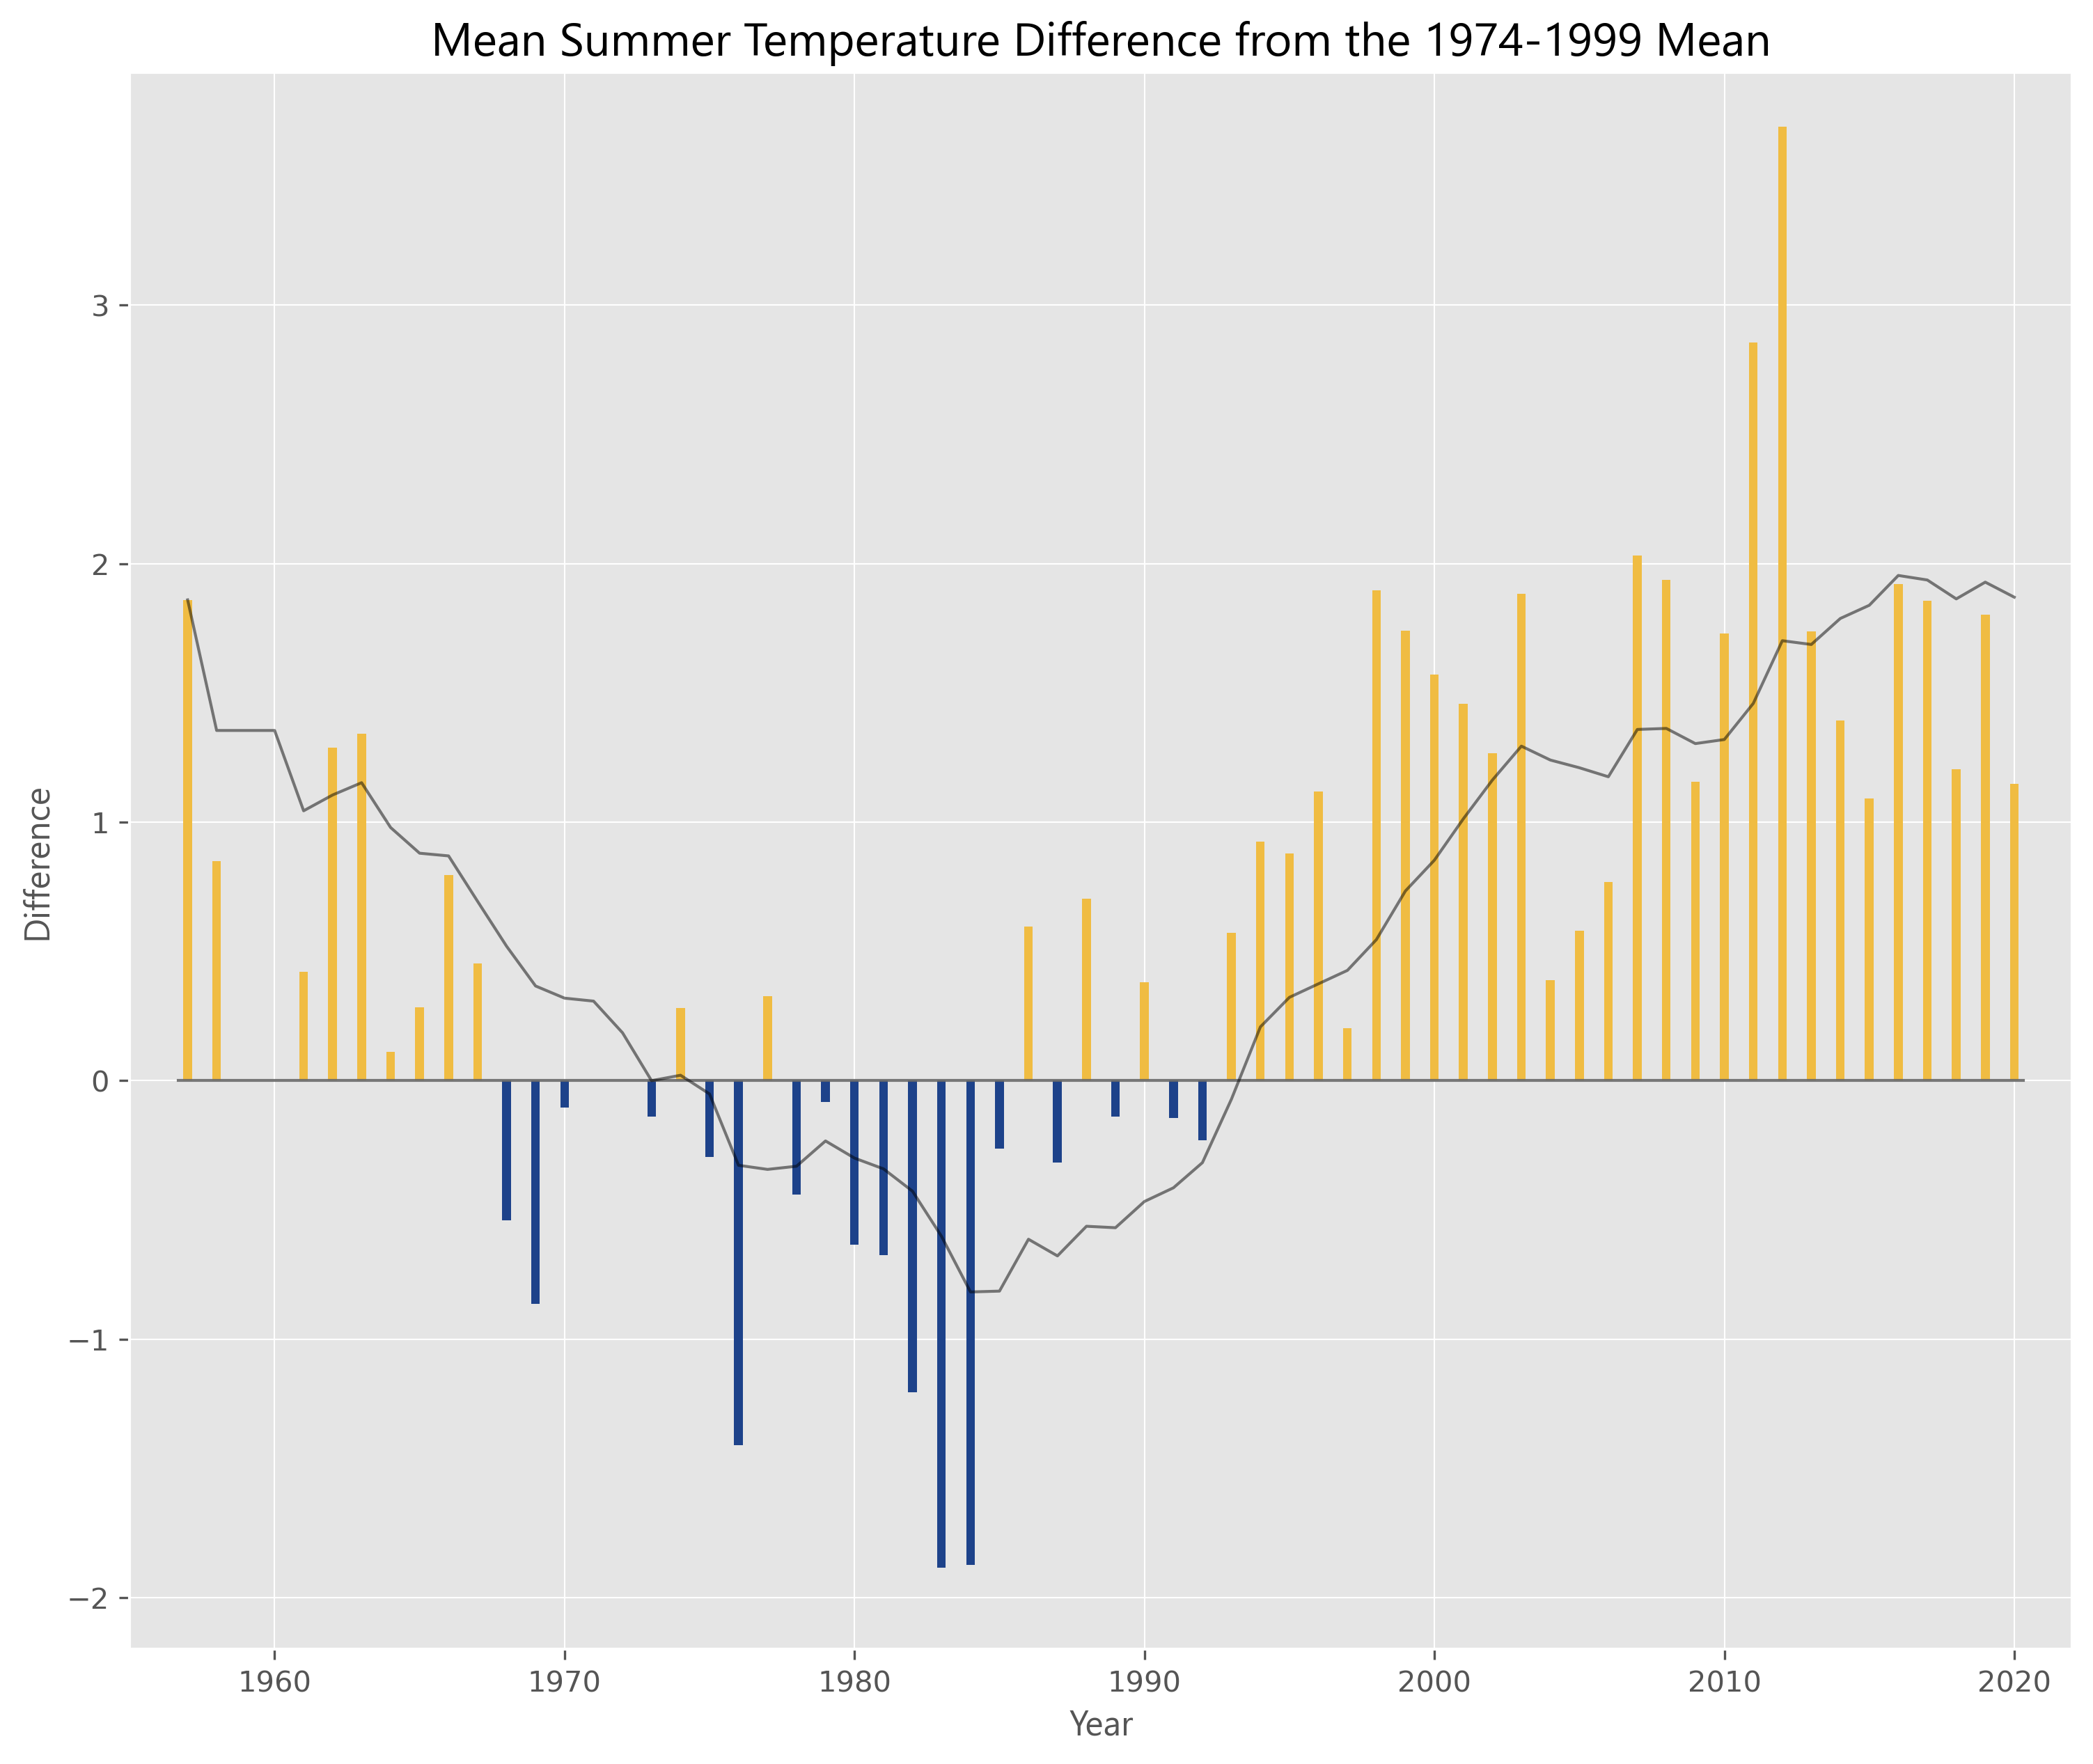

In [23]:
#Time for some plotting
csfont = {'fontname':'Segoe UI'}
hfont = {'fontname':'Segoe UI'}

plt.style.use('ggplot')
plt.figure(figsize=(12, 10),dpi=300)
plt.tight_layout()
plt.title('Mean Summer Temperature Difference from the 1974-1999 Mean',**hfont,fontsize=16)
plt.xlabel('Year',**hfont)
plt.ylabel('Difference',**hfont)
plt.xlim(min(summer['yy']),(max(summer['yy'])+2))
plt.ylim(-2.2,3.9)
colormat=np.where(summer['diff']>0, '#F0BC42','#1D428A')
plt.axhline(y=0, color='dimgray',alpha = 0.9, linestyle='-',lw = 1, xmin = 0.025,xmax = 0.975)
plt.plot(summer['yy'],summer['rolling'],color = 'black',alpha = 1.5, lw =1)
plt.bar(x = summer['yy'], height = summer['diff'],width = 0.3,color=colormat)
plt.savefig('Mean Summer Difference.png',dpi = 600)

# Question 3
## Average Daily Temperatures


#### For the purpose of this question
* A new dataset _av_ will be created as a copy of the main dataset _df_
* Then a new column 'mmdd' wil be created, with the combination of month and day, in order to get a comparable version of daily temperature for the whole per year range
* The rolling average for will be calculated

In [25]:
av = df
av['mmdd'] = av['date'].dt.strftime('%m-%d')
av = av.sort_values(by="date")
av = av.drop(columns = ['prcp','dd'])
av['rolling'] = av['tavg'].rolling(30, min_periods=1).mean()

In [26]:
av

date  tavg    yy  mm   mmdd    rolling
0     1955-01-01   NaN  1955   1  01-01        NaN
1     1955-01-02   NaN  1955   1  01-02        NaN
2     1955-01-03   NaN  1955   1  01-03        NaN
3     1955-01-04   NaN  1955   1  01-04        NaN
4     1955-01-05   NaN  1955   1  01-05        NaN
...          ...   ...   ...  ..    ...        ...
23246 2020-12-27  16.6  2020  12  12-27  14.086667
23247 2020-12-28  14.8  2020  12  12-28  14.153333
23248 2020-12-29  16.3  2020  12  12-29  14.153333
23249 2020-12-30  16.4  2020  12  12-30  14.193333
23250 2020-12-31  15.4  2020  12  12-31  14.293333

[24104 rows x 6 columns]

Now the same can be applied for the baseline (black line on the plot). 
* A new dataframe base2 will be created for the years 1974-1999
* The aggregate result of the mean of the tavg will be stored in the tavg column for the corresponding month-day combination
* The rolling average will be calculated here, too


In [27]:
base2 = df[(df['yy']>= 1974) & 
                  (df['yy']<=1999)]
base2 = base2.groupby(base2['mmdd']).agg({'tavg':'mean'})
base2['rolling'] = base2['tavg'].rolling(30, min_periods=1, center=False).mean()

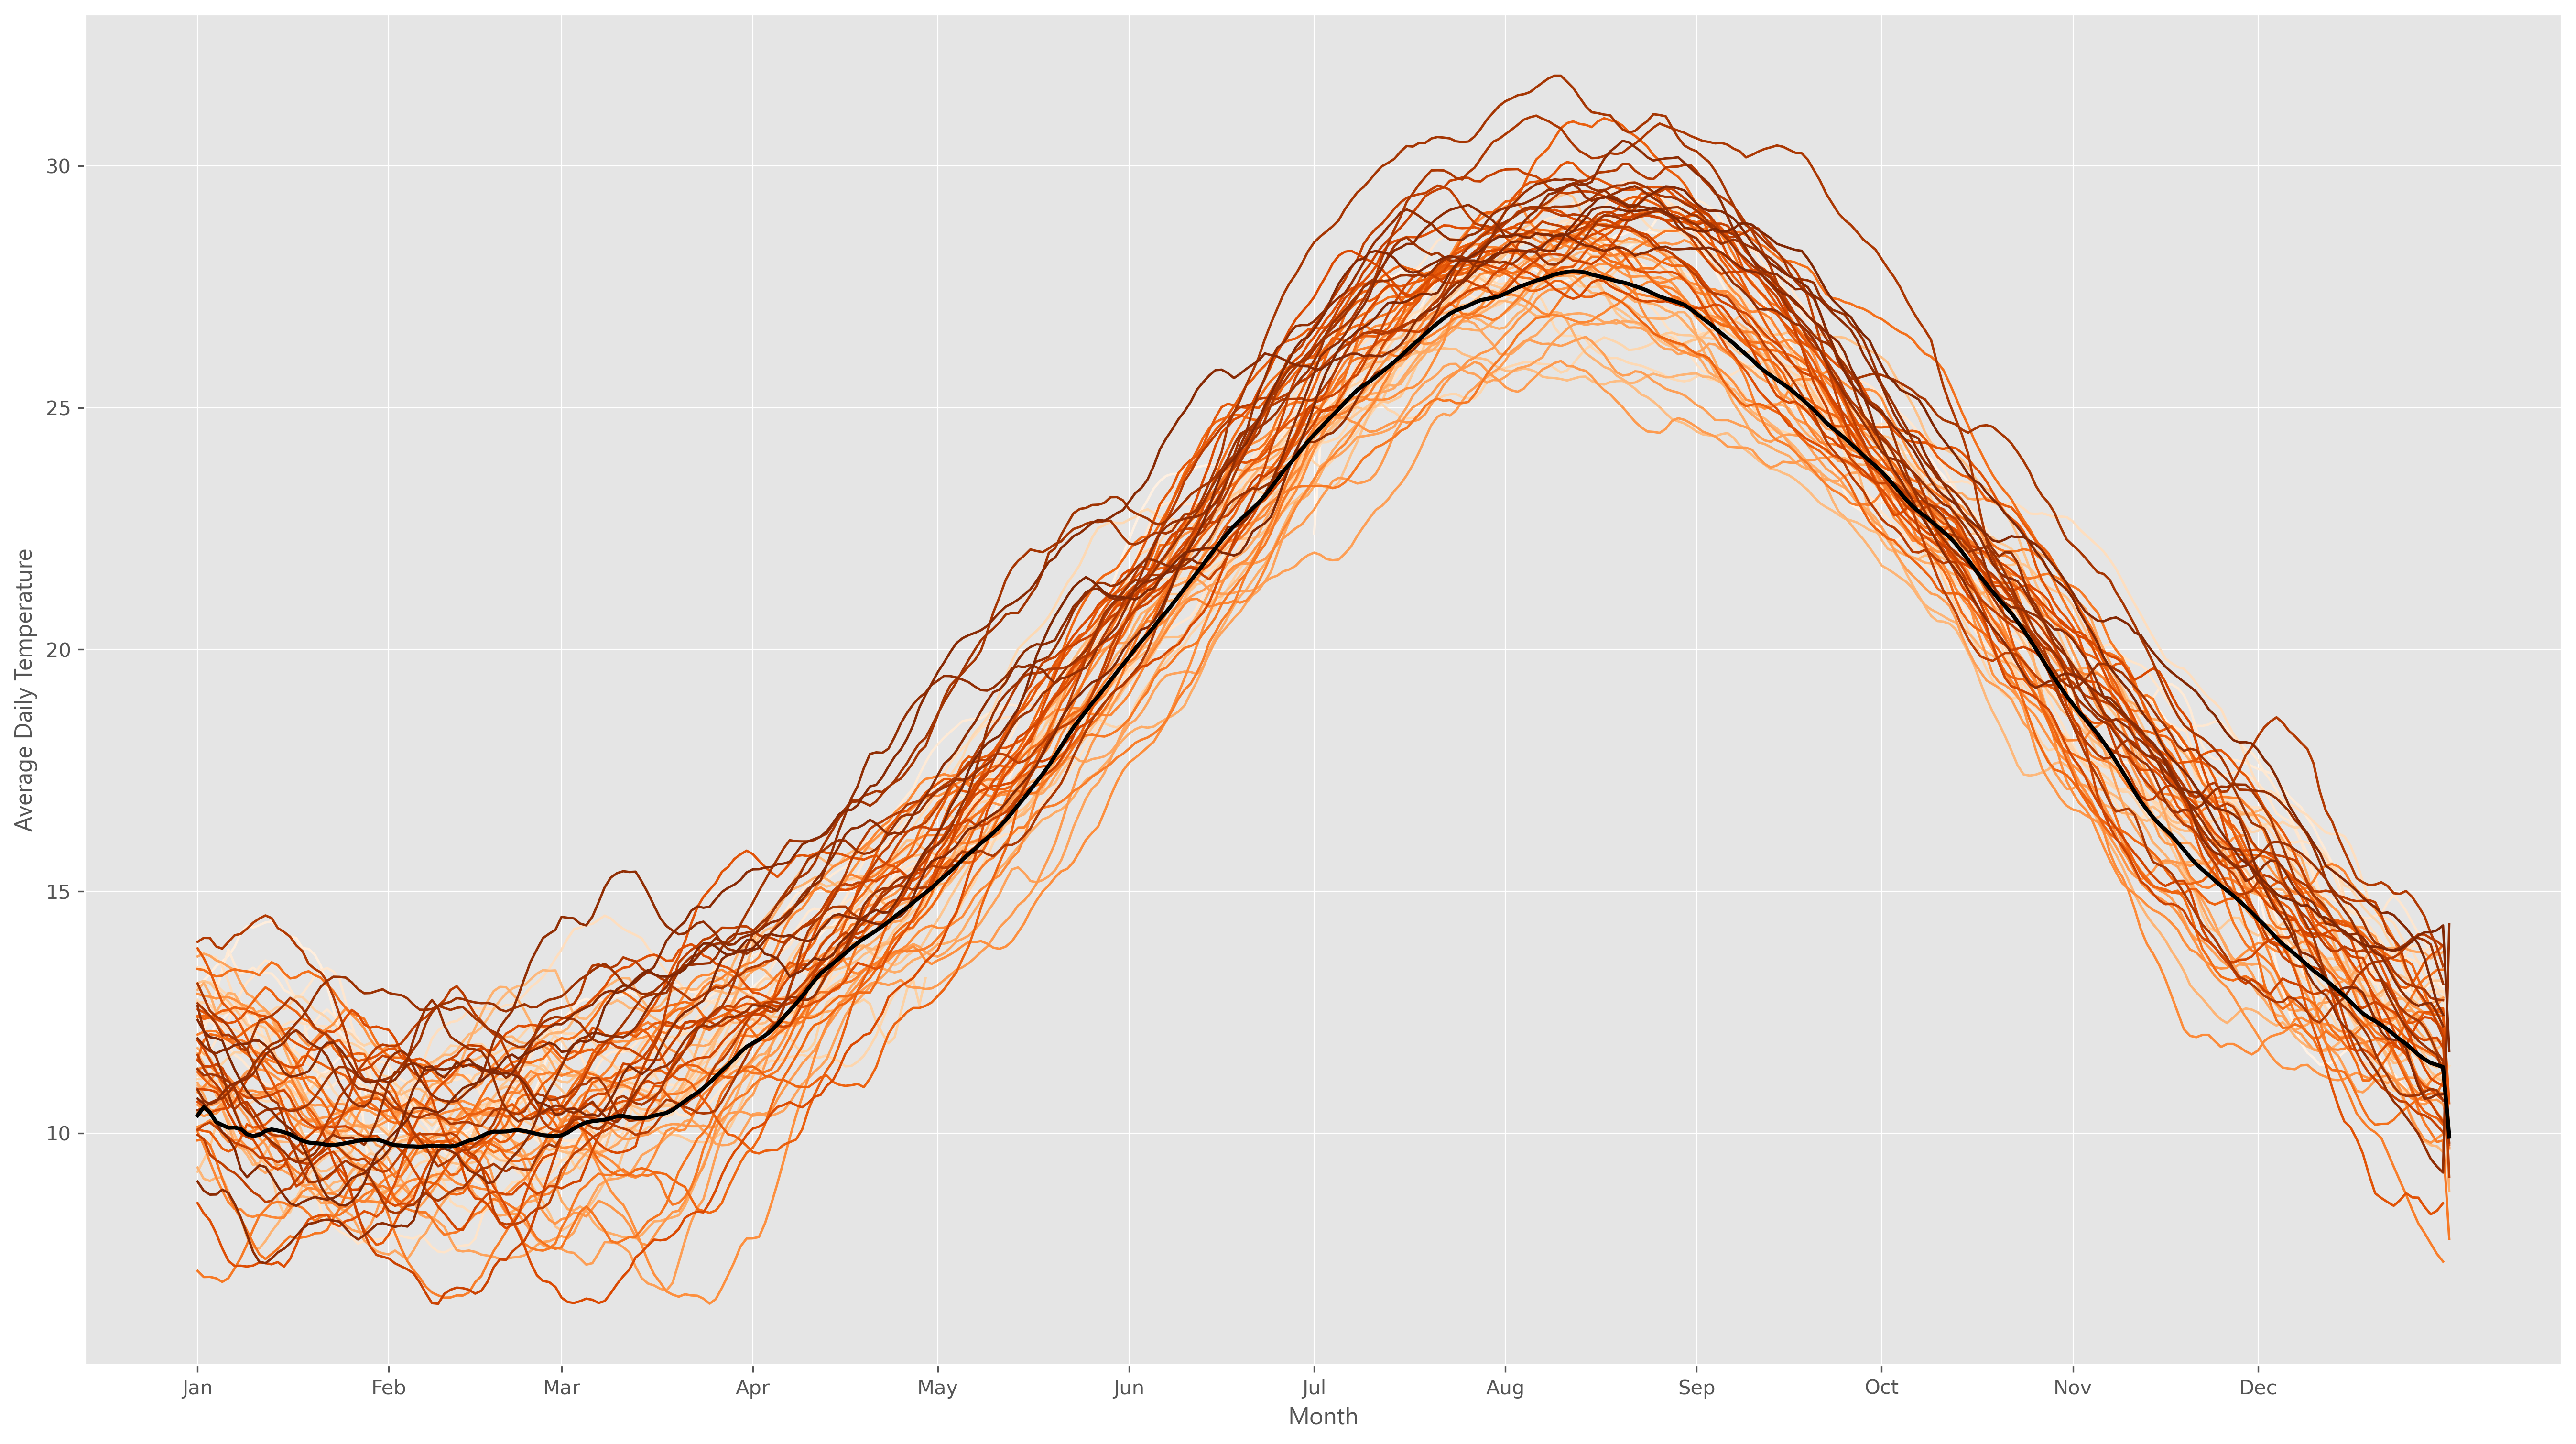

In [33]:
csfont = {'fontname':'Segoe UI'}
hfont = {'fontname':'Segoe UI'}

fig = plt.figure(figsize=(18, 10),dpi = 300)

ax = fig.add_subplot()
plt.style.use('ggplot')
plt.tight_layout()
ax.set_xlabel('Month',**hfont)
ax.set_ylabel('Average Daily Temperature',**hfont)
sns.lineplot(data=av, x="mmdd", y="rolling", hue = 'yy',palette="Oranges", lw = 1.2,ci=None)
sns.lineplot(data=base2,x="mmdd",y="rolling", color = "black", lw = 2,ci=None)
plt.xticks(['01-01','02-01','03-01','04-01','05-01','06-01','07-01','08-01','09-01','10-01','11-01','12-01'],
           ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.legend([],[], frameon=False)

# Question 4

## Extreme Temperature Events

In [38]:
base2 = df[(df['yy']>= 1974) & 
                  (df['yy']<=1999)]
base2 = base2.groupby('mmdd').mean()
base2 = base2.reset_index()
base2 = base2.drop(columns=['prcp','yy','mm','dd'])

In [39]:
base2 = base2.groupby('mmdd').mean()


In [40]:
base2['baseline'] = base2['tavg']*1.1

In [41]:
base2

tavg   baseline
mmdd                       
01-01  10.365385  11.401923
01-02  10.707692  11.778462
01-03  10.207692  11.228462
01-04   9.634615  10.598077
01-05   9.919231  10.911154
...          ...        ...
12-27   9.769231  10.746154
12-28  10.207692  11.228462
12-29  10.776923  11.854615
12-30  11.353846  12.489231
12-31  11.007692  12.108462

[366 rows x 2 columns]

In [42]:
df3 = df2.merge(base2,how = 'inner', on = 'mmdd') 


NameError: name 'df2' is not defined

In [43]:
df3 = df3.sort_values(by="date")
df3

NameError: name 'df3' is not defined

In [333]:
df3['greater'] = df3['tavg_x']>df3['baseline']

In [334]:
df3['greater'] = df3['greater'].astype(int)

In [335]:
df4 = df3.groupby('yy').size()

In [336]:
df4 = pd.DataFrame(data = df4)
df4.columns = ['tot']

In [337]:
df3 = df3.groupby('yy').sum()

df3

tavg_x       tavg_y     baseline  greater
yy                                                  
1955     0.000000  6518.288308  7170.117138        0
1956     0.000000  6527.654974  7180.420472        0
1957  3914.000000  6518.288308  7170.117138       52
1958  6829.500000  6518.288308  7170.117138      130
1959     0.000000  6518.288308  7170.117138        0
...           ...          ...          ...      ...
2016  7090.166667  6527.654974  7180.420472      159
2017  7001.266667  6518.288308  7170.117138      170
2018  7121.866667  6518.288308  7170.117138      173
2019  7015.200000  6518.288308  7170.117138      163
2020  7069.000000  6527.654974  7180.420472      168

[66 rows x 4 columns]

In [338]:
df3 = df3.merge(df4,how = 'inner', on = 'yy')

In [339]:
df3['pct'] = df3['greater']/df3['tot']

In [340]:
df3 = df3.reset_index()

In [341]:
df3

yy       tavg_x       tavg_y     baseline  greater  tot       pct
0   1955     0.000000  6518.288308  7170.117138        0  365  0.000000
1   1956     0.000000  6527.654974  7180.420472        0  366  0.000000
2   1957  3914.000000  6518.288308  7170.117138       52  365  0.142466
3   1958  6829.500000  6518.288308  7170.117138      130  365  0.356164
4   1959     0.000000  6518.288308  7170.117138        0  365  0.000000
..   ...          ...          ...          ...      ...  ...       ...
61  2016  7090.166667  6527.654974  7180.420472      159  366  0.434426
62  2017  7001.266667  6518.288308  7170.117138      170  365  0.465753
63  2018  7121.866667  6518.288308  7170.117138      173  365  0.473973
64  2019  7015.200000  6518.288308  7170.117138      163  365  0.446575
65  2020  7069.000000  6527.654974  7180.420472      168  366  0.459016

[66 rows x 7 columns]

In [342]:
base3 = df[(df['yy']>= 1974) & 
                  (df['yy']<=1999)]

In [344]:
base3 = base3.merge(base2, how = 'inner', on = 'mmdd')

In [346]:
base3['greater'] = base3['tavg_x']>base3['baseline']

In [347]:
base3

date  tavg_x  prcp    yy  mm  dd   mmdd     tavg_y   baseline  \
0    1974-01-01    11.6   0.0  1974   1   1  01-01  10.365385  11.401923   
1    1975-01-01     8.7  13.8  1975   1   1  01-01  10.365385  11.401923   
2    1976-01-01    11.3   0.0  1976   1   1  01-01  10.365385  11.401923   
3    1977-01-01    10.2   0.0  1977   1   1  01-01  10.365385  11.401923   
4    1978-01-01     7.0   3.1  1978   1   1  01-01  10.365385  11.401923   
...         ...     ...   ...   ...  ..  ..    ...        ...        ...   
9491 1980-02-29     3.4   0.5  1980   2  29  02-29   9.366667  10.303333   
9492 1984-02-29    13.6   0.0  1984   2  29  02-29   9.366667  10.303333   
9493 1988-02-29    10.7   0.0  1988   2  29  02-29   9.366667  10.303333   
9494 1992-02-29    10.6   0.0  1992   2  29  02-29   9.366667  10.303333   
9495 1996-02-29     6.8   0.0  1996   2  29  02-29   9.366667  10.303333   

      greater  
0        True  
1       False  
2       False  
3       False  
4       False  
...       ...  
9491    False  
9492     True  
9493     True  
9494     True  
9495    False  

[9496 rows x 10 columns]

9496

In [351]:
base3['greater'] = base3['greater'].astype(int)

basepct = base3['greater'].sum()/len(base3)

In [358]:
basepct

0.24842038753159226

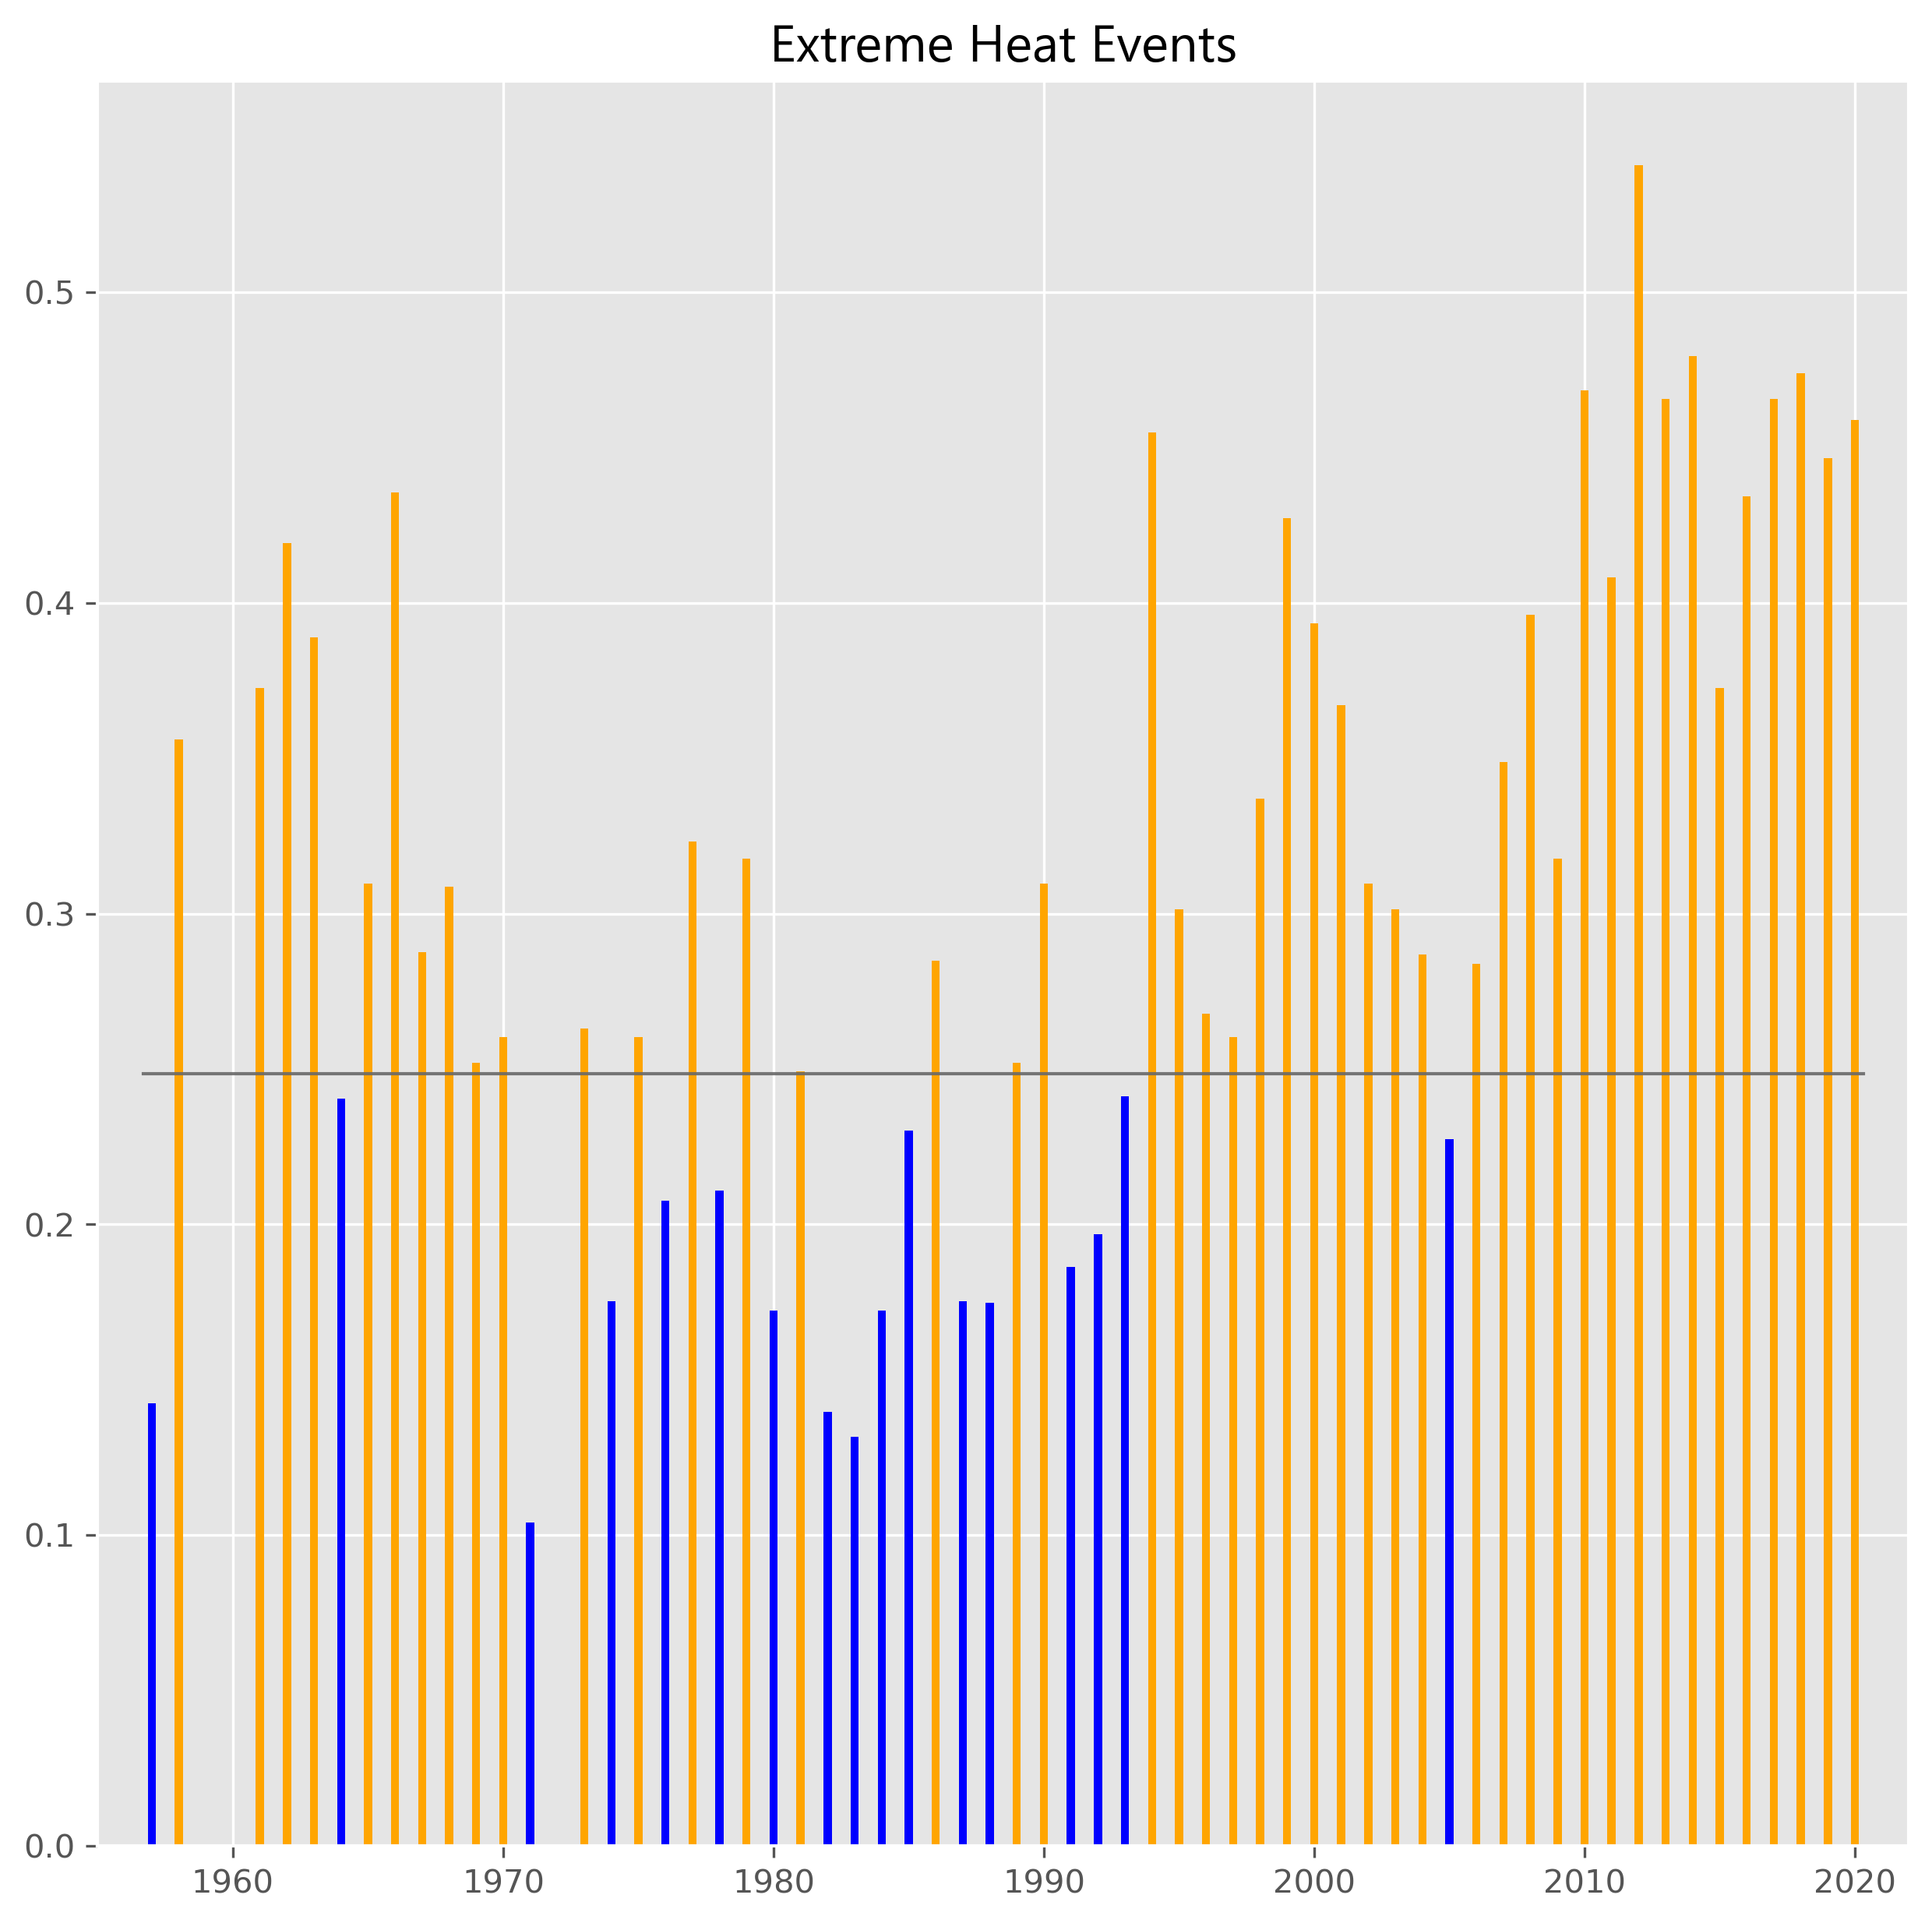

In [362]:
#Time for some plotting

csfont = {'fontname':'Segoe UI'}
hfont = {'fontname':'Segoe UI'}

plt.style.use('ggplot')
plt.figure(figsize=(10, 10),dpi=300)
plt.tight_layout()
plt.title('Extreme Heat Events',**hfont,fontsize=16)

plt.xlim(min(df3['yy']),(max(df3['yy'])+2))
plt.axhline(y=basepct, color='dimgray',alpha = 0.9, linestyle='-',lw = 1, xmin = 0.025,xmax = 0.975)
colormat=np.where(df3['pct']>basepct, 'orange','blue')
plt.bar(x = df3['yy'], height = df3['pct'],width = 0.3,color=colormat)
plt.savefig('Extreme Heat Events.png',dpi = 600)

# Question 5
## Precipitation


In [364]:
rain = df.drop(columns='tavg')

In [366]:
rain1 = rain.groupby('yy').sum()

In [372]:
rain1

prcp    mm    dd
yy                     
1955  547.0  2382  5738
1956  281.3  2384  5767
1957  303.2  2382  5738
1958  350.0  2382  5738
1959  214.0  2382  5738
...     ...   ...   ...
2016  261.6  2384  5767
2017  304.3  2382  5738
2018  380.2  2382  5738
2019  570.0  2382  5738
2020  210.4  2384  5767

[66 rows x 3 columns]

In [369]:
rain2 = rain

In [370]:
rain2['count'] = rain['prcp']>0
rain2['count'] = rain2['count'].astype(int)

In [373]:
rain2 = rain2.groupby('yy').sum()

In [374]:
rain2

prcp    mm    dd  count
yy                            
1955  547.0  2382  5738     68
1956  281.3  2384  5767     52
1957  303.2  2382  5738     73
1958  350.0  2382  5738     68
1959  214.0  2382  5738     62
...     ...   ...   ...    ...
2016  261.6  2384  5767     42
2017  304.3  2382  5738     48
2018  380.2  2382  5738     55
2019  570.0  2382  5738     58
2020  210.4  2384  5767     38

[66 rows x 4 columns]

In [376]:
rainf = rain1.merge(rain2, how = 'inner',on = 'yy')

In [379]:
rainf['div'] = rainf['prcp_x']/rainf['count']

In [382]:
rainf['rolling'] = rainf['div'].rolling(10, min_periods=1, center=False).mean()

In [384]:
rainf = rainf.reset_index()

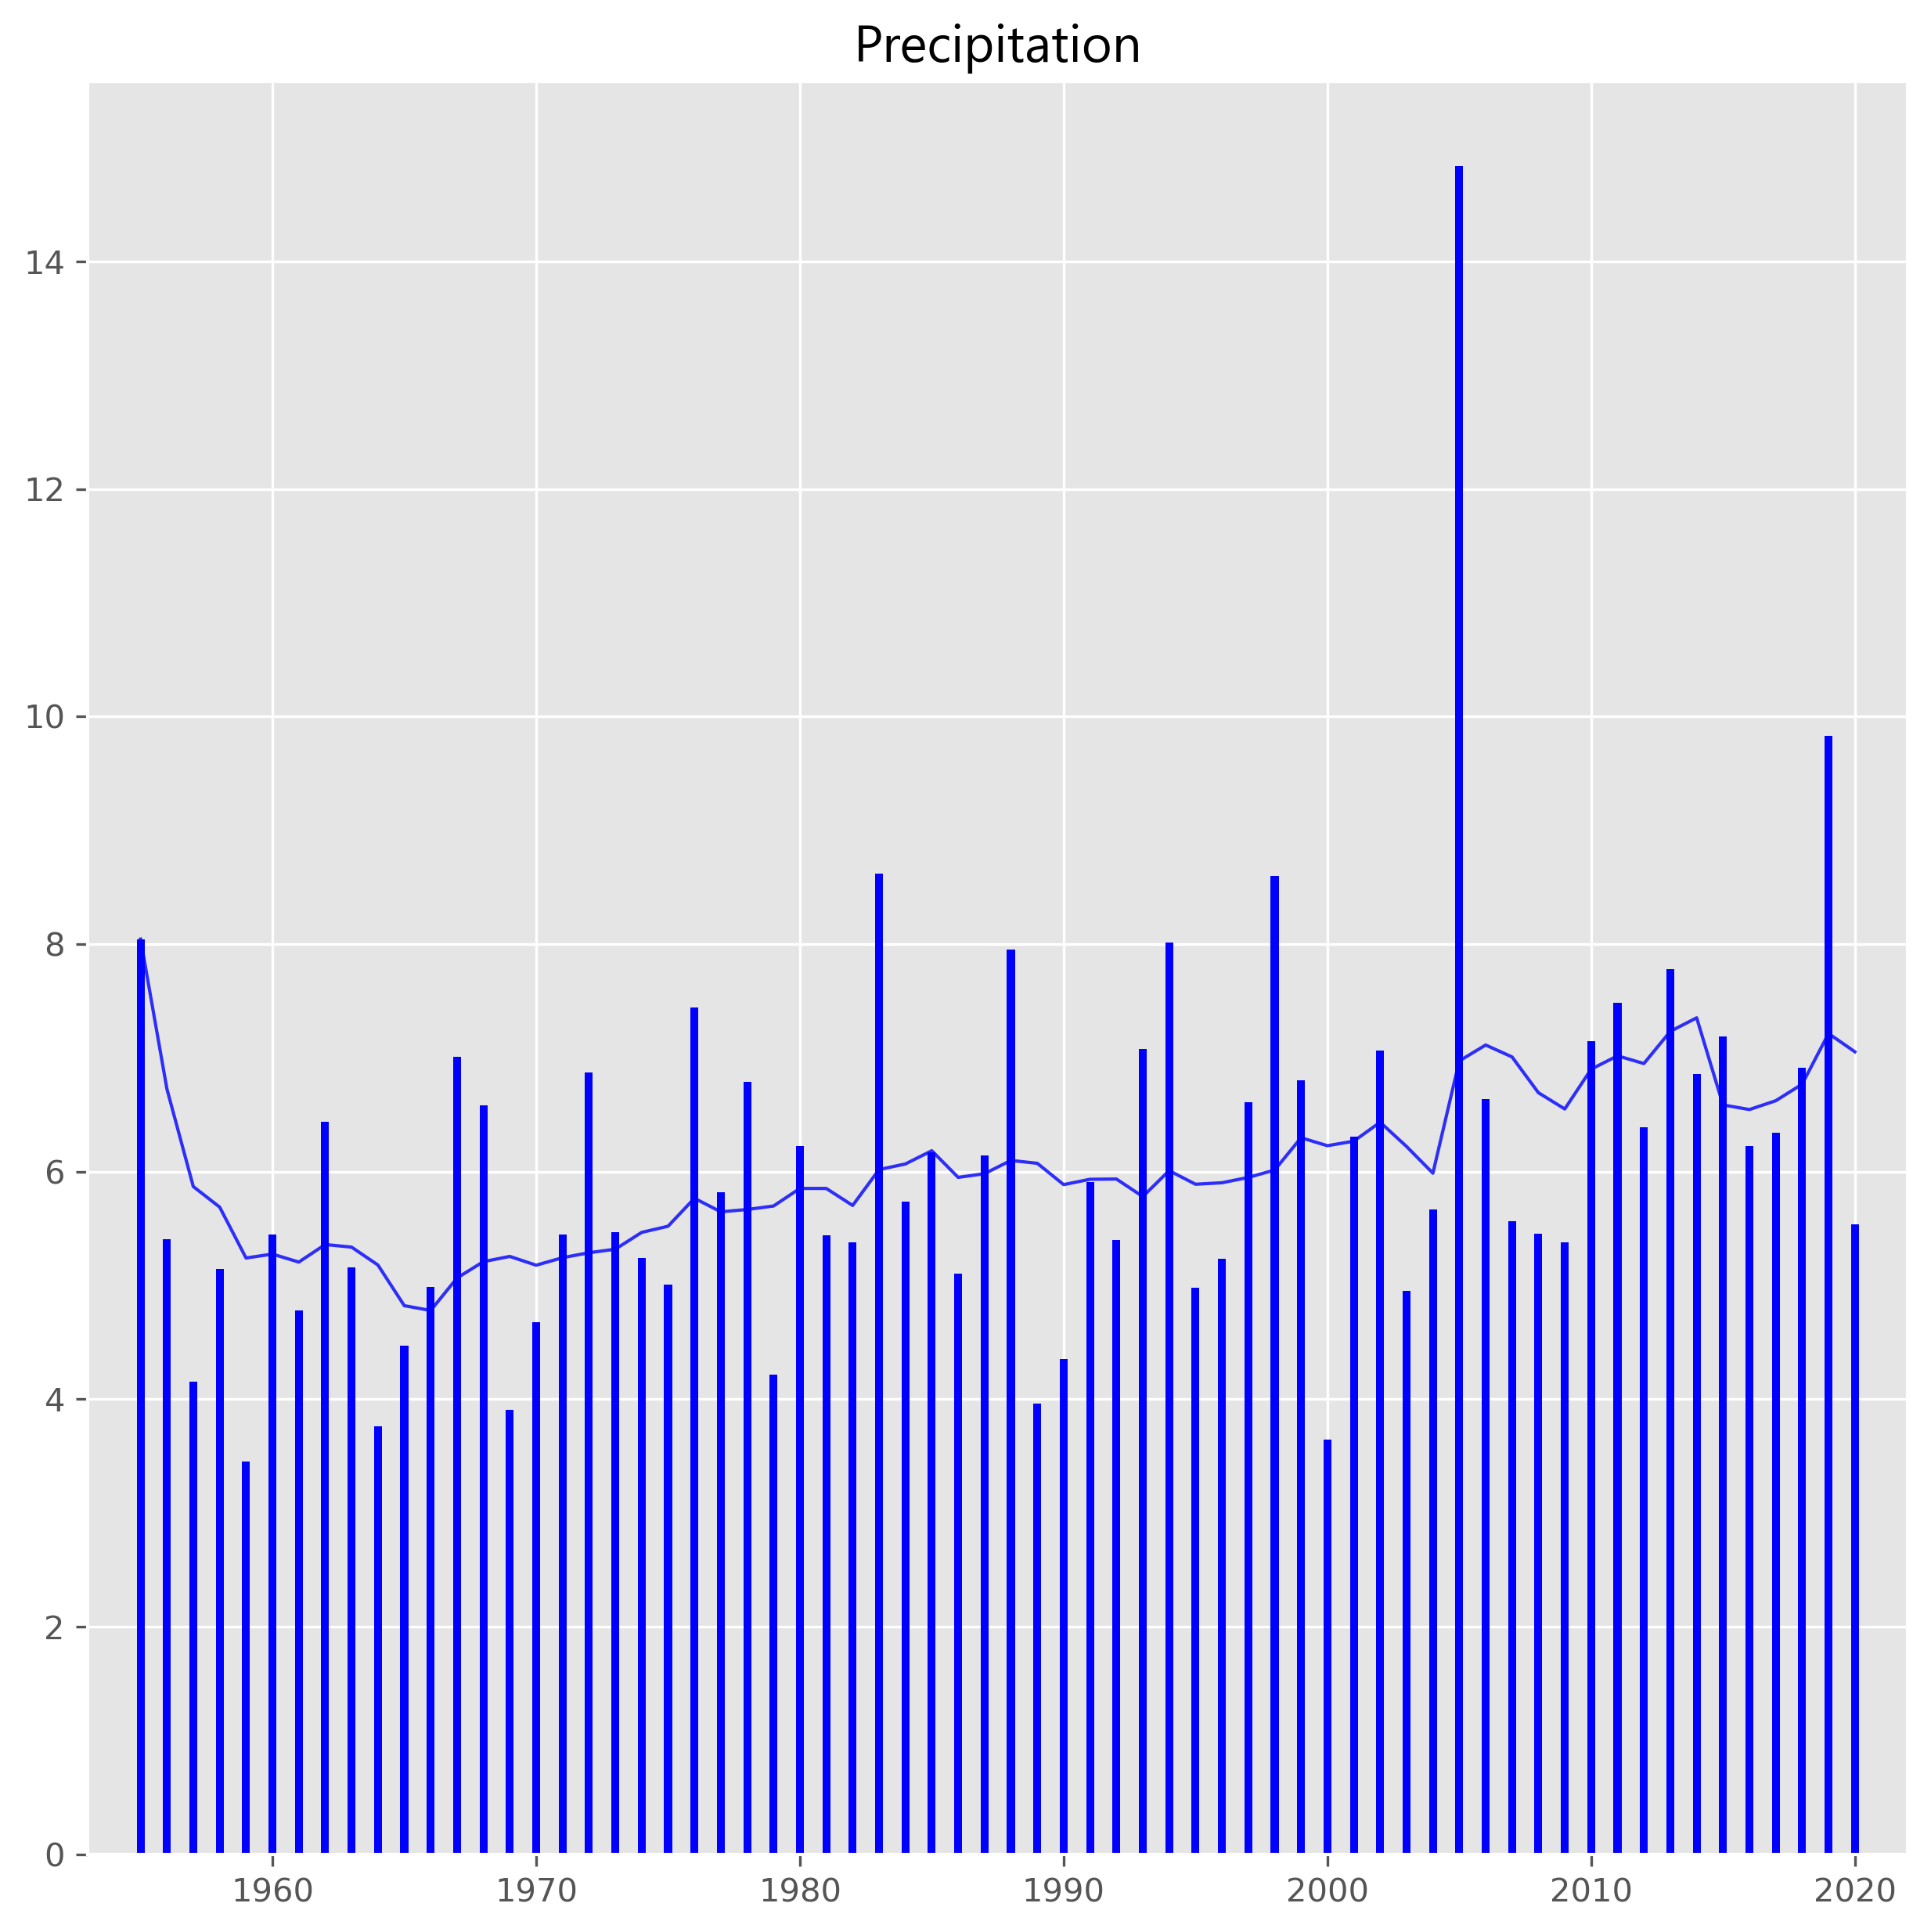

In [389]:
#Time for some plotting

csfont = {'fontname':'Segoe UI'}
hfont = {'fontname':'Segoe UI'}

plt.style.use('ggplot')
plt.figure(figsize=(10, 10),dpi=300)
plt.tight_layout()
plt.title('Precipitation',**hfont,fontsize=16)
plt.xlim((min(rainf['yy']-2)),(max(rainf['yy'])+2))
plt.bar(x = rainf['yy'], height = rainf['div'],width = 0.3,color='blue')
plt.plot(rainf['yy'],rainf['rolling'],color = 'blue',alpha = 0.8, lw =1)
plt.savefig('Precipitation.png',dpi = 600)